# Generating a more realistic dataset

Real-world point clouds are not necessarily oriented to the same point, almost always contain some noise, etc.

In this notebook we will generate a more realistic dataset from the manually orientated and 0 noise 3D point clouds by adding copies of the original clouds:

- randomly rotated 
- with noise
- with random oclussions

In [1]:
import h5py
import numpy as np
import pandas as pd
from voxelgrid import VoxelGrid
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.cmap'] = 'gray'

# Load 1 digit  to try the functions

In [3]:
TRAIN_PATH = "../train_point_clouds.h5"

In [21]:
TEST_PATH = "../test_point_clouds.h5"

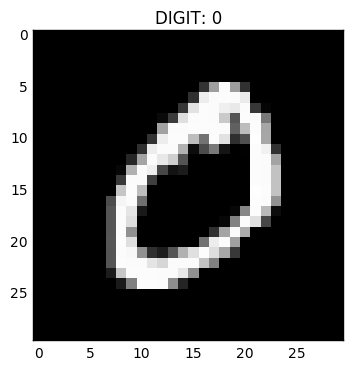

In [4]:
with h5py.File(TRAIN_PATH, "r") as hf:    

    a = hf["1"]
    
    digit = (a["img"][:], a["points"][:], a.attrs["label"]) 


plt.title("DIGIT: " + str(digit[2]))
plt.imshow(digit[0])

In [5]:
original = VoxelGrid(digit[1], x_y_z=[16,16,16])

# Rotation functions

The clouds have 0 mean so we can use this rotation matrices.

In [6]:
def Rx(angle, degrees=True):
    """ 
    """
    if degrees:
        
        cx = np.cos(np.deg2rad(angle))
        sx = np.sin(np.deg2rad(angle))
        
    else:
        
        cx = np.cos(angle)
        sx = np.sin(angle)
        
    Rx = np.array(
    [[1  , 0  , 0  ],
     [0  , cx , sx ],
     [0  , -sx, cx]]
    )
    
    return Rx

In [7]:
def Ry(angle, degrees=True):
    
    if degrees:
        
        cy = np.cos(np.deg2rad(angle))
        sy = np.sin(np.deg2rad(angle))
        
    else:
        
        cy = np.cos(angle)
        sy = np.sin(angle)
        
    Ry = np.array(
    [[cy , 0  , -sy],
     [0  , 1  , 0  ],
     [sy , 0  , cy]]
    )
    
    return Ry

In [8]:
def Rz(angle, degrees=True):
        
    if degrees:
        
        cz = np.cos(np.deg2rad(angle))
        sz = np.sin(np.deg2rad(angle))
        
    else:
        
        cz = np.cos(angle)
        sz = np.sin(angle)
        
    Rz = np.array(
    [[cz , sz , 0],
     [-sz, cz , 0],
     [0  , 0  , 1]]
    )
        
    return Rz

### Original

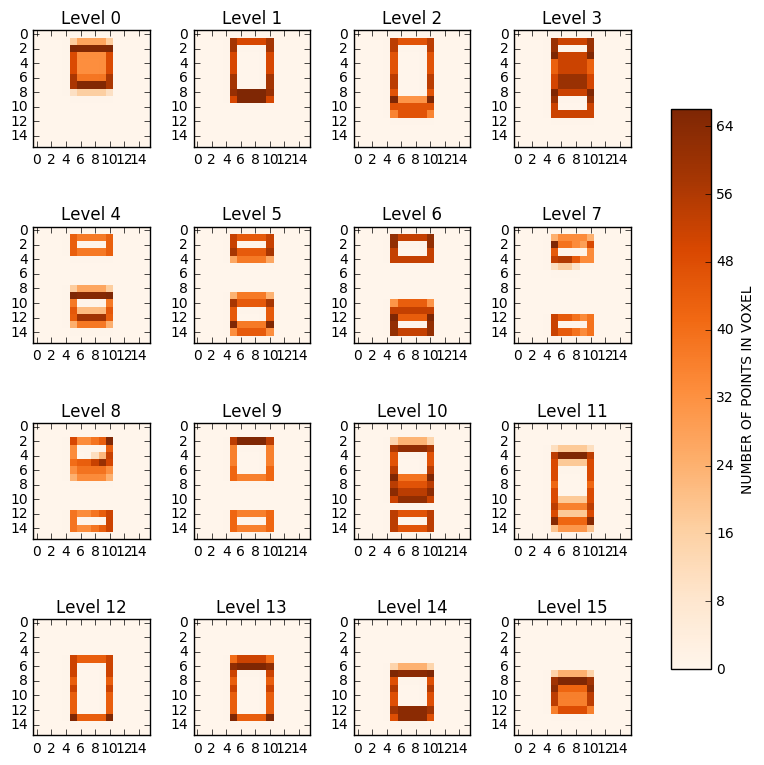

In [9]:
original.plot()

### Rotate 60º around Z axis

In [10]:
rotated_z = VoxelGrid(digit[1] @ Rz(60), x_y_z=[16,16,16])

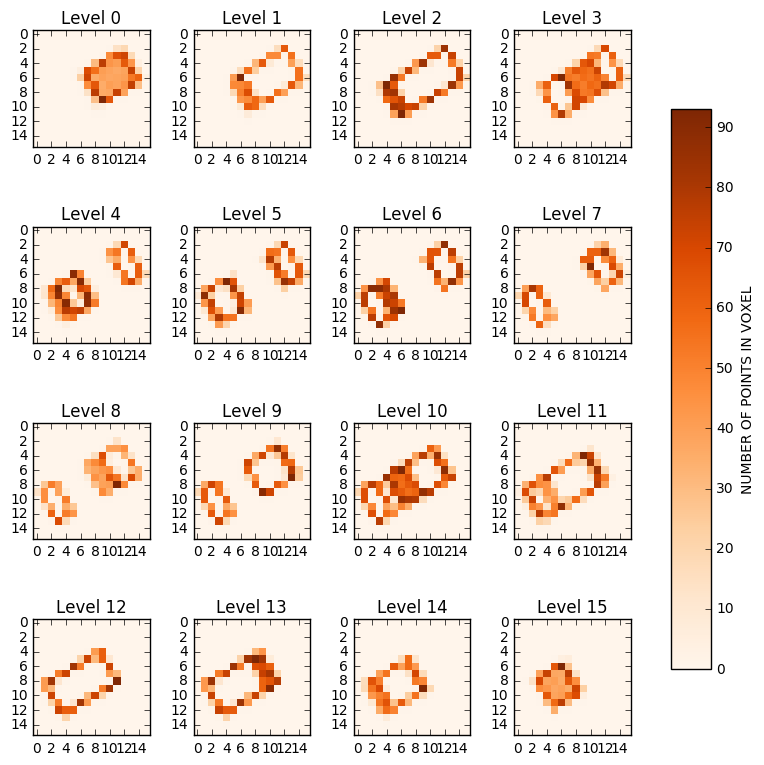

In [11]:
rotated_z.plot()

### Rotate 90º around Y axis

In [12]:
rotated_y = VoxelGrid(digit[1] @ Ry(90), x_y_z=[16,16,16])

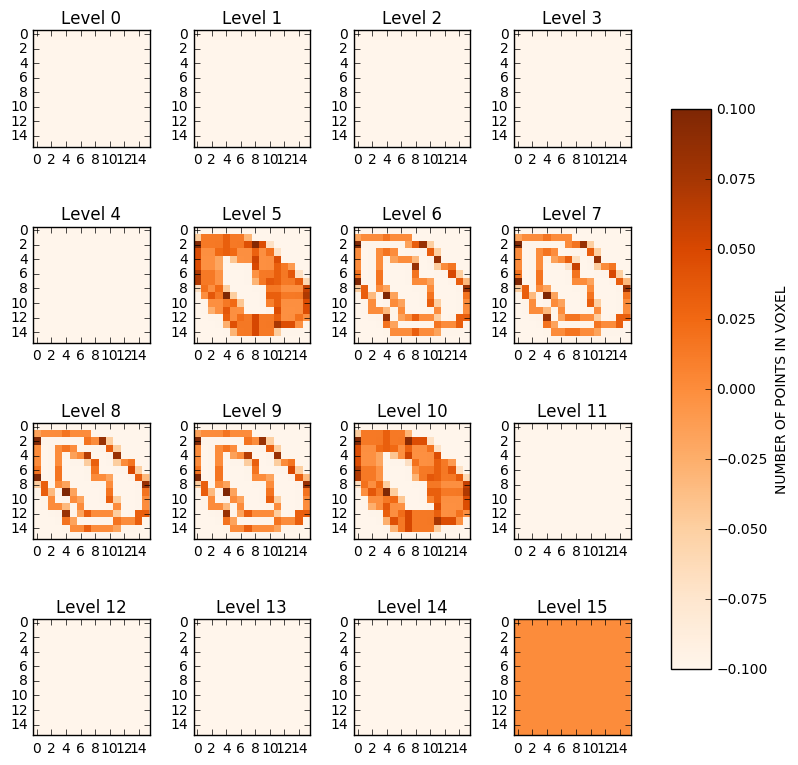

In [13]:
rotated_y.plot()

### Adding noise

In [14]:
def add_noise(xyz, strength=0.25):
    std = xyz.std(0) * strength
    noise = np.zeros_like(xyz)
    for i in range(3):
        noise[:,i] += np.random.uniform(-std[i], std[i], xyz.shape[0])
    return xyz + noise  
    
    

In [15]:
with_nosie = VoxelGrid(add_noise(digit[1]), x_y_z=[16,16,16])

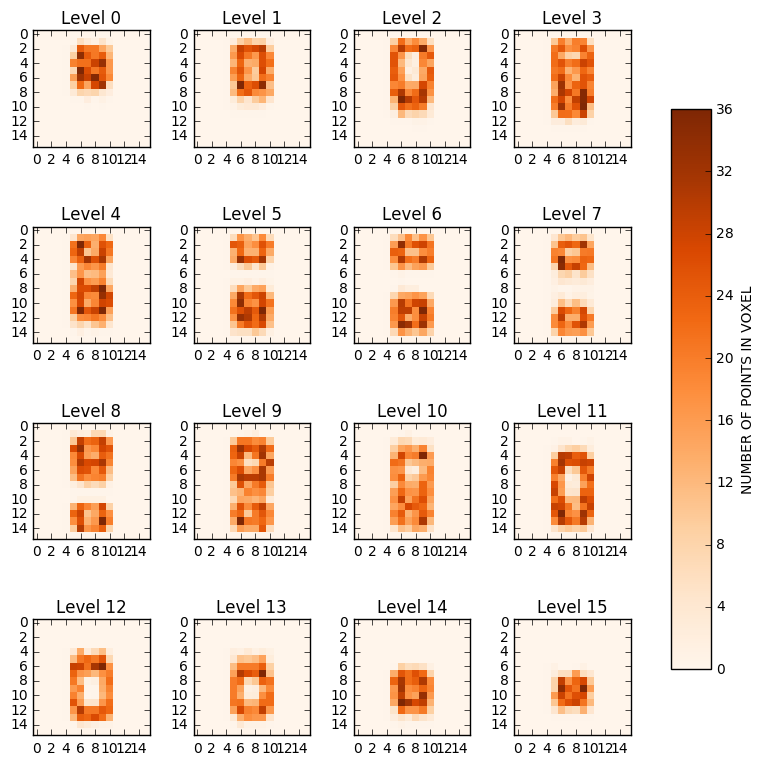

In [16]:
with_nosie.plot()

### Oclussions

Adding random oclusions will be easier to implement directly on the VoxelGrid so I'll implement this augmentation as part of the training process.

## Generate augmented dataset

In [17]:
save = True

In [18]:
if save: # grab a coffe and wait
    with h5py.File(TRAIN_PATH, "r") as hf:
        size = len(hf.keys())

        out = []        
        for i in range(size):
            if i % 200 == 0:
                print(i, "\t processed")
                
            original_cloud = hf[str(i)]["points"][:]
            label = hf[str(i)].attrs["label"]
            
            voxelgrid = VoxelGrid(original_cloud, x_y_z=[16, 16, 16])

            vector = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)
            
            out.append(vector.tolist().append(label))  

            s_x = np.random.normal(0, 90)
            s_y = np.random.normal(0, 90)
            s_z = np.random.normal(0, 180)

            cloud = original_cloud @ Rz(s_z) @ Ry(s_y) @ Rx(s_x)

            cloud = add_noise(cloud)

            voxelgrid = VoxelGrid(cloud, x_y_z=[16, 16, 16])

            vector = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)

            out.append(vector.tolist().append(label))
            
        print("[DONE]")

0 	 processed
200 	 processed
400 	 processed
600 	 processed
800 	 processed
1000 	 processed
1200 	 processed
1400 	 processed
1600 	 processed
1800 	 processed
2000 	 processed
2200 	 processed
2400 	 processed
2600 	 processed
2800 	 processed
3000 	 processed
3200 	 processed
3400 	 processed
3600 	 processed
3800 	 processed
4000 	 processed
4200 	 processed
4400 	 processed
4600 	 processed
4800 	 processed
[DONE]


In [19]:
train = pd.DataFrame(out)

In [20]:
train.to_csv("train_16_16_16.csv", index=False)

In [23]:
if save: # grab a coffe and wait
    with h5py.File(TEST_PATH, "r") as hf:
        size = len(hf.keys())

        out = []        
        for i in range(size):
            if i % 200 == 0:
                print(i, "\t processed")
                
            original_cloud = hf[str(i)]["points"][:]
            label = hf[str(i)].attrs["label"]
            
            voxelgrid = VoxelGrid(original_cloud, x_y_z=[16, 16, 16])

            vector = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)
            
            out.append(vector.tolist().append(label))  

            s_x = np.random.normal(0, 90)
            s_y = np.random.normal(0, 90)
            s_z = np.random.normal(0, 180)

            cloud = original_cloud @ Rz(s_z) @ Ry(s_y) @ Rx(s_x)

            cloud = add_noise(cloud)

            voxelgrid = VoxelGrid(cloud, x_y_z=[16, 16, 16])

            vector = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)

            out.append(vector.tolist().append(label))
            
        print("[DONE]")

0 	 processed
200 	 processed
400 	 processed
600 	 processed
800 	 processed
[DONE]


In [24]:
test = pd.DataFrame(out)

In [25]:
test.to_csv("test_16_16_16.csv", index=False)